In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import warnings
import os

In [2]:
# 시각화 선명도
%config InlineBackend.figure_format = 'retina' 
# 한글설정 축의 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# warining 경고 안보이게
warnings.filterwarnings(action='ignore')
# warining 경고 보이게
# warnings.filterwarnings(action='default')

In [3]:
movies_processing = pd.read_csv('../프로젝트csv/movies.csv')

In [4]:
# 월_계절 컬럼 만들기
def movie_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

In [5]:
movies_processing['개봉월'] = pd.to_numeric(movies_processing['개봉월'], errors='coerce')
movies_processing['계절'] = movies_processing['개봉월'].apply(movie_season)
movies_processing['계절']

0       4
1       4
2       4
3       4
4       4
       ..
6019    3
6020    2
6021    3
6022    3
6023    2
Name: 계절, Length: 6024, dtype: int64

In [6]:
# 장르2를 만들어 번호와 이름이 같이 출력할수있게 딕셔너리로 변경
movies_genre = {movie:idx   for idx, movie in enumerate(movies_processing['장르'].unique())}
# movies_genre
movies_processing['장르2'] = movies_processing['장르'].map(movies_genre)
print(movies_processing[['장르', '장르2']].head())

      장르  장르2
0  애니메이션    0
1  애니메이션    0
2     액션    1
3    드라마    2
4  애니메이션    0


In [7]:
# 데이터 준비 (분류분석)
# 라벨인코딩 
le = LabelEncoder()
movies_processing['등급_le'] = le.fit_transform(movies_processing['등급'])
movies_processing['관람객수_le'] = le.fit_transform(movies_processing['관람객수'])
movies_processing['계절_le'] = le.fit_transform(movies_processing['계절'])

X = movies_processing[['장르2', '총스크린수', '관람객수_le', '등급_le']]
y = movies_processing['계절_le']

In [8]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4819, 4), (4819,), (1205, 4), (1205,))

In [9]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)), # 입력데이터의 colunm 수
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(movies_processing['계절_le'].unique()), activation='softmax')  # 계절의 개수만큼 출력층 생성
])

In [11]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)

# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_sea-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                            verbose=1)               

hist = model.fit(X_train, y_train, 
                 epochs = 500, 
                 validation_split = 0.2, 
                 callbacks = [checkpoint, earlyStopping]
                )

Epoch 1/500
115/121 [===========================>..] - ETA: 0s - loss: 1.3878 - accuracy: 0.2622
Epoch 1: val_accuracy improved from -inf to 0.29253, saving model to ./model\movies_sea-001-val0.2925.h5
121/121 [==============================] - 2s 5ms/step - loss: 1.3876 - accuracy: 0.2628 - val_loss: 1.3795 - val_accuracy: 0.2925
Epoch 2/500
116/121 [===========================>..] - ETA: 0s - loss: 1.3822 - accuracy: 0.2748
Epoch 2: val_accuracy did not improve from 0.29253
121/121 [==============================] - 0s 3ms/step - loss: 1.3827 - accuracy: 0.2739 - val_loss: 1.3831 - val_accuracy: 0.2687
Epoch 3/500
106/121 [=========================>....] - ETA: 0s - loss: 1.3784 - accuracy: 0.2851
Epoch 3: val_accuracy did not improve from 0.29253
121/121 [==============================] - 0s 4ms/step - loss: 1.3800 - accuracy: 0.2848 - val_loss: 1.3814 - val_accuracy: 0.2770
Epoch 4/500
113/121 [===========================>..] - ETA: 0s - loss: 1.3762 - accuracy: 0.2926
Epoch 4: val

Epoch 29/500
115/121 [===========================>..] - ETA: 0s - loss: 1.3405 - accuracy: 0.3467
Epoch 29: val_accuracy improved from 0.32884 to 0.32988, saving model to ./model\movies_sea-029-val0.3299.h5
121/121 [==============================] - 1s 4ms/step - loss: 1.3402 - accuracy: 0.3473 - val_loss: 1.3580 - val_accuracy: 0.3299
Epoch 30/500
121/121 [==============================] - ETA: 0s - loss: 1.3413 - accuracy: 0.3463
Epoch 30: val_accuracy did not improve from 0.32988
121/121 [==============================] - 0s 4ms/step - loss: 1.3413 - accuracy: 0.3463 - val_loss: 1.3618 - val_accuracy: 0.3216
Epoch 31/500
119/121 [============================>.] - ETA: 0s - loss: 1.3358 - accuracy: 0.3527
Epoch 31: val_accuracy did not improve from 0.32988
121/121 [==============================] - 0s 4ms/step - loss: 1.3362 - accuracy: 0.3523 - val_loss: 1.3611 - val_accuracy: 0.3174
Epoch 32/500
109/121 [==========================>...] - ETA: 0s - loss: 1.3345 - accuracy: 0.3432
Ep

Epoch 57/500
110/121 [==========================>...] - ETA: 0s - loss: 1.2924 - accuracy: 0.3838
Epoch 57: val_accuracy did not improve from 0.35062
121/121 [==============================] - 0s 4ms/step - loss: 1.2893 - accuracy: 0.3875 - val_loss: 1.3479 - val_accuracy: 0.3413
Epoch 58/500
119/121 [============================>.] - ETA: 0s - loss: 1.2945 - accuracy: 0.3842
Epoch 58: val_accuracy did not improve from 0.35062
121/121 [==============================] - 1s 5ms/step - loss: 1.2951 - accuracy: 0.3834 - val_loss: 1.3443 - val_accuracy: 0.3382
Epoch 59/500
110/121 [==========================>...] - ETA: 0s - loss: 1.2856 - accuracy: 0.3869
Epoch 59: val_accuracy did not improve from 0.35062
121/121 [==============================] - 1s 4ms/step - loss: 1.2890 - accuracy: 0.3860 - val_loss: 1.3510 - val_accuracy: 0.3392
Epoch 60/500
115/121 [===========================>..] - ETA: 0s - loss: 1.2900 - accuracy: 0.3837
Epoch 60: val_accuracy did not improve from 0.35062
121/121

Epoch 85/500
117/121 [============================>.] - ETA: 0s - loss: 1.2496 - accuracy: 0.4140
Epoch 85: val_accuracy did not improve from 0.37967
121/121 [==============================] - 1s 4ms/step - loss: 1.2506 - accuracy: 0.4122 - val_loss: 1.3442 - val_accuracy: 0.3558
Epoch 86/500
114/121 [===========================>..] - ETA: 0s - loss: 1.2511 - accuracy: 0.4167
Epoch 86: val_accuracy did not improve from 0.37967
121/121 [==============================] - 1s 6ms/step - loss: 1.2536 - accuracy: 0.4153 - val_loss: 1.3395 - val_accuracy: 0.3683
Epoch 87/500
119/121 [============================>.] - ETA: 0s - loss: 1.2586 - accuracy: 0.4191
Epoch 87: val_accuracy did not improve from 0.37967
121/121 [==============================] - 0s 3ms/step - loss: 1.2574 - accuracy: 0.4195 - val_loss: 1.3393 - val_accuracy: 0.3620
Epoch 88/500
116/121 [===========================>..] - ETA: 0s - loss: 1.2493 - accuracy: 0.4014
Epoch 88: val_accuracy did not improve from 0.37967
121/121

116/121 [===========================>..] - ETA: 0s - loss: 1.2213 - accuracy: 0.4302
Epoch 113: val_accuracy did not improve from 0.40145
121/121 [==============================] - 0s 3ms/step - loss: 1.2192 - accuracy: 0.4324 - val_loss: 1.3230 - val_accuracy: 0.4004
Epoch 114/500
117/121 [============================>.] - ETA: 0s - loss: 1.2176 - accuracy: 0.4324
Epoch 114: val_accuracy did not improve from 0.40145
121/121 [==============================] - 0s 3ms/step - loss: 1.2198 - accuracy: 0.4322 - val_loss: 1.3297 - val_accuracy: 0.3911
Epoch 115/500
102/121 [========================>.....] - ETA: 0s - loss: 1.2099 - accuracy: 0.4305
Epoch 115: val_accuracy did not improve from 0.40145
121/121 [==============================] - 0s 3ms/step - loss: 1.2169 - accuracy: 0.4259 - val_loss: 1.3378 - val_accuracy: 0.3890
Epoch 116/500
105/121 [=========================>....] - ETA: 0s - loss: 1.2142 - accuracy: 0.4366
Epoch 116: val_accuracy did not improve from 0.40145
121/121 [====

Epoch 142/500
109/121 [==========================>...] - ETA: 0s - loss: 1.1883 - accuracy: 0.4484
Epoch 142: val_accuracy improved from 0.40560 to 0.41183, saving model to ./model\movies_sea-142-val0.4118.h5
121/121 [==============================] - 1s 4ms/step - loss: 1.1925 - accuracy: 0.4470 - val_loss: 1.3294 - val_accuracy: 0.4118
Epoch 143/500
119/121 [============================>.] - ETA: 0s - loss: 1.1965 - accuracy: 0.4404
Epoch 143: val_accuracy did not improve from 0.41183
121/121 [==============================] - 1s 4ms/step - loss: 1.1967 - accuracy: 0.4399 - val_loss: 1.3133 - val_accuracy: 0.3963
Epoch 144/500
107/121 [=========================>....] - ETA: 0s - loss: 1.1862 - accuracy: 0.4501
Epoch 144: val_accuracy did not improve from 0.41183
121/121 [==============================] - 1s 4ms/step - loss: 1.1893 - accuracy: 0.4459 - val_loss: 1.3204 - val_accuracy: 0.3932
Epoch 145/500
118/121 [============================>.] - ETA: 0s - loss: 1.1905 - accuracy: 0.

Epoch 171/500
115/121 [===========================>..] - ETA: 0s - loss: 1.1690 - accuracy: 0.4465
Epoch 171: val_accuracy did not improve from 0.41183
121/121 [==============================] - 0s 4ms/step - loss: 1.1728 - accuracy: 0.4451 - val_loss: 1.3368 - val_accuracy: 0.4108
Epoch 172/500
111/121 [==========================>...] - ETA: 0s - loss: 1.1637 - accuracy: 0.4513
Epoch 172: val_accuracy did not improve from 0.41183
121/121 [==============================] - 0s 4ms/step - loss: 1.1650 - accuracy: 0.4516 - val_loss: 1.3509 - val_accuracy: 0.4087
Epoch 173/500
114/121 [===========================>..] - ETA: 0s - loss: 1.1651 - accuracy: 0.4594
Epoch 173: val_accuracy did not improve from 0.41183
121/121 [==============================] - 0s 4ms/step - loss: 1.1627 - accuracy: 0.4602 - val_loss: 1.3486 - val_accuracy: 0.4098
Epoch 174/500
120/121 [============================>.] - ETA: 0s - loss: 1.1715 - accuracy: 0.4536
Epoch 174: val_accuracy did not improve from 0.41183

In [12]:
# 모델 평가하기 
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 2ms/step - loss: 1.3518 - accuracy: 0.4008
accuracy : 40.08 %


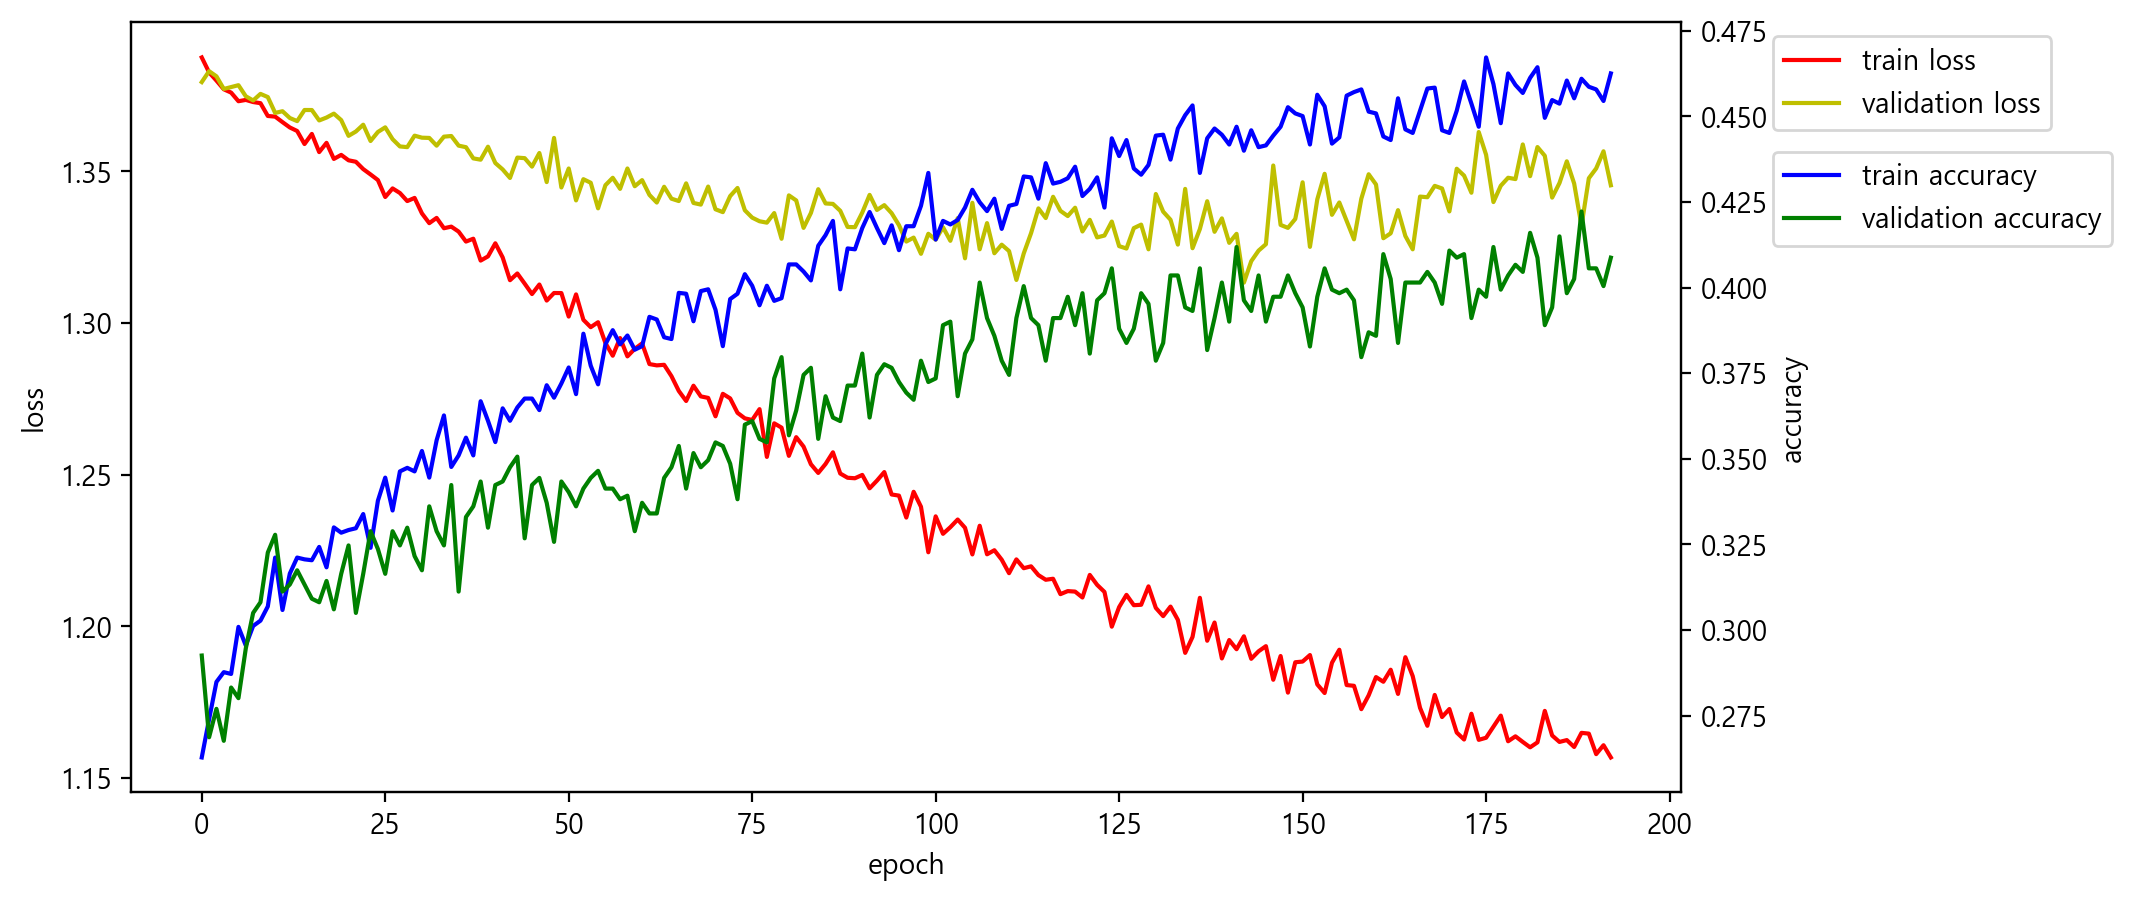

In [14]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10, 5))

# Loss 그래프
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

# Accuracy 그래프 (y축 공유)
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')

# 범례(legend) 위치 조정 - 바깥으로 이동
loss_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # loss legend
acc_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.85))  # accuracy legend

# 그래프 표시
plt.show()

In [ ]:
movies_processing.to_csv('../프로젝트csv/movies.csv', index=False, encoding='utf-8')